MSc Data Science Thesis code. \
Predicting the probability of critical illness insurance claims as a form of noncommunicable disease management. \
This is the first of two notebooks demonstrating the application of the proposed approach. \
Details of the proposed approach can be found in the proposed_methodology.py script. \
In this notebook, critical illness claims are modelled using critical illness insurance coverage information and client demographic information only.

# Project Set up

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from dateutil.relativedelta import relativedelta
from scipy.stats import randint, loguniform, uniform

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier

In [4]:
from proposed_methodology import ProposedMethodology
from create_data_partitions import create_train_test, create_claim_train_test

In [5]:
%aimport proposed_methodology, create_data_partitions

In [6]:
sns.set()

In [7]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.3}'.format)

In [8]:
pd.__version__

'2.2.3'

# Load Dataset

In [9]:
df = pd.read_csv('DATA/CI_CVGS.csv', low_memory=False)

In [10]:
#Some columns of the dataset are private
display_cols = ['CLAIM', 'START_AGE', 'TENURE', 'MATURITY_AGE', 'TIME_TO_MATURE', 
                'SEX_CD', 'SUM_INSURED', 'SMOKER', 'MARITAL_STATUS', 'INCOME', 'YEARS_EMPLOYED']

In [11]:
df.loc[:, display_cols].head()

,CLAIM,START_AGE,TENURE,MATURITY_AGE,TIME_TO_MATURE,SEX_CD,SUM_INSURED,SMOKER,MARITAL_STATUS,INCOME,YEARS_EMPLOYED
0,0,42,149,70,10078,M,1e+05,0,UNKNOWN,5000,13
1,0,36,303,65,10289,M,1e+05,0,UNKNOWN,12000,1
2,0,28,918,65,12596,F,1e+06,0,UNKNOWN,0,0
3,0,33,3291,65,8397,M,2.5e+05,0,MARRIED,1666,6
4,0,40,728,65,8403,F,2.5e+05,0,MARRIED,8333,10


In [12]:
print('Size of dataset: ', df.shape)
print('Number of unique clients: ', df['MDM_ID'].nunique())
print('Number of CI claims observed:', df['CLAIM'].sum())

Size of dataset:  (110402, 18)
Number of unique clients:  89510
Number of CI claims observed: 2135


In [13]:
#Convert columns to datetime format
cols = ['START_DT', 'END_DT', 'MATURITY_DT', 'DOB']
for col in cols:
    df.loc[:, col] = pd.to_datetime(df[col])

In [14]:
#Convert columns to appropriate formats, prevent pandas nullable types as these are incompatible with sci-kit
df = df.convert_dtypes(convert_floating=False, convert_integer=False)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110402 entries, 0 to 110401
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   MDM_ID          110402 non-null  int64         
 1   CLI_ID          110402 non-null  int64         
 2   CVG_ID          110402 non-null  string        
 3   CLAIM           110402 non-null  int64         
 4   START_AGE       110402 non-null  int64         
 5   TENURE          110402 non-null  int64         
 6   START_DT        110402 non-null  datetime64[ns]
 7   END_DT          110402 non-null  datetime64[ns]
 8   MATURITY_AGE    110402 non-null  int64         
 9   MATURITY_DT     110402 non-null  datetime64[ns]
 10  TIME_TO_MATURE  110402 non-null  int64         
 11  SEX_CD          110402 non-null  string        
 12  SUM_INSURED     110402 non-null  float64       
 13  SMOKER          110402 non-null  int64         
 14  MARITAL_STATUS  110402 non-null  str

In [16]:
df.loc[:, display_cols].describe()

,CLAIM,START_AGE,TENURE,MATURITY_AGE,TIME_TO_MATURE,SUM_INSURED,SMOKER,INCOME,YEARS_EMPLOYED
count,1.1e+05,1.1e+05,1.1e+05,1.1e+05,1.1e+05,1.1e+05,1.1e+05,1.1e+05,1.1e+05
mean,0.0193,32.2,1.96e+03,67.5,1.1e+04,2.01e+05,0.0925,1.09e+04,6.49
std,0.138,8.89,2.2e+03,3.55,4.08e+03,2.07e+05,0.325,4.36e+04,7.24
min,0.0,14.0,21.0,64.0,0.0,2e+04,-1.0,0.0,0.0
25%,0.0,25.0,4.17e+02,65.0,8.47e+03,1e+05,0.0,5e+03,1.0
50%,0.0,31.0,1e+03,65.0,1.15e+04,1.25e+05,0.0,7.5e+03,4.0
75%,0.0,38.0,2.79e+03,70.0,1.39e+04,2.3e+05,0.0,1.2e+04,10.0
max,1.0,65.0,1.31e+04,81.0,2.33e+04,8e+06,1.0,7e+06,82.0


# Feature engineering
- Latest age variable
- Encoding

## Variables

In [17]:
df.loc[:, 'LAST_AGE'] = df.apply(lambda x: x['START_AGE'] + relativedelta(x['END_DT'], x['START_DT']).years , axis=1)

In [18]:
#Data entry issues and date-time calculation sensitivity causes values to be imprecise, this is corrected here. 
#The maximum age on the insurance can only be 65, 70, 75 or 80.
df.loc[df['MATURITY_AGE'].between(60, 66), 'MATURITY_AGE'] = 65
df.loc[df['MATURITY_AGE'].between(67, 71), 'MATURITY_AGE'] = 70
df.loc[df['MATURITY_AGE'].between(72, 76), 'MATURITY_AGE'] = 75
df.loc[df['MATURITY_AGE'].between(77, 82), 'MATURITY_AGE'] = 80

## Encoding

In [19]:
#Sex
df.loc[:, 'SEX_F'] = np.where(df['SEX_CD'] == 'F', 1, 0)
df.loc[:, 'SEX_M'] = np.where(df['SEX_CD'] == 'M', 1, 0)

In [20]:
df[['SEX_CD', 'SEX_F', 'SEX_M']].value_counts()

SEX_CD  SEX_F  SEX_M
F       1      0        56077
M       0      1        54325
Name: count, dtype: int64

In [21]:
#Smoker
df.loc[:, 'SMOKER_Y'] = np.where(df['SMOKER'] == 1, 1, 0)
df.loc[:, 'SMOKER_N'] = np.where(df['SMOKER'] != 1, 1, 0)

In [22]:
df[['SMOKER', 'SMOKER_Y','SMOKER_N']].value_counts()

SMOKER  SMOKER_Y  SMOKER_N
 0      0         1           97805
 1      1         0           11402
-1      0         1            1195
Name: count, dtype: int64

In [23]:
#Marital status
df.loc[:, 'MARITAL_STATUS_SINGLE'] = np.where(df['MARITAL_STATUS'] == 'SINGLE', 1, 0)
df.loc[:, 'MARITAL_STATUS_MARRIED'] = np.where(df['MARITAL_STATUS'] == 'MARRIED', 1, 0)
df.loc[:, 'MARITAL_STATUS_OTHER'] = np.where(df['MARITAL_STATUS'].isin(['COMMONLAW', 'SEPARATED', 'OTHER', 'UNKNOWN']), 1, 0)

In [24]:
df[['MARITAL_STATUS', 'MARITAL_STATUS_SINGLE', 'MARITAL_STATUS_MARRIED', 'MARITAL_STATUS_OTHER']].value_counts()

MARITAL_STATUS  MARITAL_STATUS_SINGLE  MARITAL_STATUS_MARRIED  MARITAL_STATUS_OTHER
SINGLE          1                      0                       0                       57754
MARRIED         0                      1                       0                       41666
COMMONLAW       0                      0                       1                        6322
SEPARATED       0                      0                       1                        3958
UNKNOWN         0                      0                       1                         528
OTHER           0                      0                       1                         174
Name: count, dtype: int64

# Missing Data Handling
- Check for number of nulls
     - If entire column is null drop column
     - If entire row is null drop row
- Replace outliers and missing values with median as appropriate

In [25]:
df.isna().sum()

MDM_ID                    0
CLI_ID                    0
CVG_ID                    0
CLAIM                     0
START_AGE                 0
TENURE                    0
START_DT                  0
END_DT                    0
MATURITY_AGE              0
MATURITY_DT               0
TIME_TO_MATURE            0
SEX_CD                    0
SUM_INSURED               0
SMOKER                    0
MARITAL_STATUS            0
INCOME                    0
YEARS_EMPLOYED            0
DOB                       0
LAST_AGE                  0
SEX_F                     0
SEX_M                     0
SMOKER_Y                  0
SMOKER_N                  0
MARITAL_STATUS_SINGLE     0
MARITAL_STATUS_MARRIED    0
MARITAL_STATUS_OTHER      0
dtype: int64

# Modelling datasets
Here the major partitions of the data are demonstrated. Test sets contained CI coverages ending after 2023 and 2024. All other data up to the year of the test set were used for training and validation. Validation sets were created through ScikitLearn’s (SKL) TimeSeriesSplit CV. This process is embedded in the proposed method code so this section is for illustrative purposes only.

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110402 entries, 0 to 110401
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   MDM_ID                  110402 non-null  int64         
 1   CLI_ID                  110402 non-null  int64         
 2   CVG_ID                  110402 non-null  string        
 3   CLAIM                   110402 non-null  int64         
 4   START_AGE               110402 non-null  int64         
 5   TENURE                  110402 non-null  int64         
 6   START_DT                110402 non-null  datetime64[ns]
 7   END_DT                  110402 non-null  datetime64[ns]
 8   MATURITY_AGE            110402 non-null  int64         
 9   MATURITY_DT             110402 non-null  datetime64[ns]
 10  TIME_TO_MATURE          110402 non-null  int64         
 11  SEX_CD                  110402 non-null  string        
 12  SUM_INSURED             110402

In [27]:
partitions = pd.DataFrame(columns=['year', 'part', 'cvg', 'proportion', 'cli', 'claims', 'claim_percent'])
for year in [2023, 2024]:
    X_feat, X_label, Y_feat, Y_label, Y_id = create_train_test(df, df.columns.tolist(), year, 0)
    X_size = X_feat.shape[0]
    Y_size = Y_feat.shape[0]
    Tot_size = X_feat.shape[0] + Y_feat.shape[0]
    
    train_cvg, test_cvg = X_feat['SCALAR_CVG_ID'].nunique(), Y_feat['SCALAR_CVG_ID'].nunique() 
    train_cli, test_cli = X_feat['SCALAR_MDM_ID'].nunique(), Y_feat['SCALAR_MDM_ID'].nunique() 
    train_claims, test_claims = X_label.sum(), Y_label.sum() 
    train_per, test_per = X_label.mean(), Y_label.mean()
    train_size, test_size = X_size/Tot_size, Y_size/Tot_size
    
    partitions.loc[len(partitions), :] = [year, 'train', train_cvg, train_size, train_cli, train_claims, train_per]
    partitions.loc[len(partitions), :] = [year, 'test', test_cvg, test_size, test_cli, test_claims, test_per]

In [28]:
partitions

,year,part,cvg,proportion,cli,claims,claim_percent
0,2023,train,97686,0.885,80440,1820,0.0186
1,2023,test,12716,0.115,11895,315,0.0248
2,2024,train,104942,0.951,85682,1984,0.0189
3,2024,test,5460,0.0495,5202,151,0.0277


# Proposed approach
The proposed approach consists of the following steps:
1. Test the 5 Machine Learning algorithms to find the model that produces the best probability estimates.
2. Select the best performing model and produce critical illness claim probability estimates for each insurance coverage.
3. Rank the coverages in order of risk and assess the ranking.

In this section we evaluate the 5 ML algorithms. \
The evaluation involves two test sets corresponding to coverages ending in 2023 and 2024. \
Additionally, time-sensitive features in the dataset are offset by interval values of 0, 90, 180, and 360 days to simulate whether the model can make accurate predictions ahead of time. This can grant up to 1 year of intervention time.

In [29]:
n_jobs = -1

In [30]:
#Limits for outlier handling via Winsorisation
#The tuple is structured as follows:
#1. Column to be adjusted, 2. Lower inlier bound, 3. Upper inlier bound
outlier_bounds = [('SCALAR_SUM_INSURED', 20000, 3e6),
                  ('SCALAR_INCOME', 0, 2e5),
                  ('SCALAR_YEARS_EMPLOYED', 0, 50)]

In [31]:
#Columns used to build the predictive model. Only coverage details and client demographic information are used.
model_cols = ['LAST_AGE', 'START_AGE', 'TENURE', 'TIME_TO_MATURE', 'MATURITY_AGE',
              'SUM_INSURED', 'INCOME', 'YEARS_EMPLOYED', 
              'SEX_F', 'SEX_M', 'SMOKER_Y', 'SMOKER_N', 
              'MARITAL_STATUS_SINGLE', 'MARITAL_STATUS_MARRIED', 'MARITAL_STATUS_OTHER']

In [32]:
max_features = len(model_cols) + 1
print('Max features: ', max_features)

Max features:  16


In [33]:
#Init the proposed methodology class
#Experiments are repeated 5 times
pm = ProposedMethodology(df, model_cols, outlier_bounds, runs=5)

In [34]:
#Set the parameters for the experiment,
#Two test years 2023, 2024
#Four offset intervals 0, 90, 180, 360
pm.set_params(test_years=[2023,2024], test_intervals=[0,90,180,360])

## Dummy classifier
It is useful to compare the results of each classifier to that of a dummy classifier.

In [35]:
scores_base = pm.dummy_results()

In [36]:
scores_base

,year,log_loss,roc_auc
0,2023,0.116,0.5
1,2024,0.126,0.5


## Logistic Regression with Elastic Net

In [37]:
lren = LogisticRegression(random_state=0, penalty='elasticnet', solver='saga', n_jobs=n_jobs)

In [38]:
#Parameter grid for the grid search with the logistic regression classifier
cv_params_lren = {
    "estimator__clf__tol": loguniform(b=1e-3, a=1e-6),
    "estimator__clf__C": loguniform(b=1e1, a=1e-1),
    "estimator__clf__l1_ratio": uniform(),
    "estimator__clf__max_iter": [10000],
    "estimator__clf__fit_intercept": [True]
}

In [39]:
#Run the experiment for this classifier and print the time it took
#Test 10 parameter combinations
start = time.time()
cls_results_lren, cls_means_lren, opt_params_lren = pm.probability_estimation(lren, cv_params_lren, 10, 5)
end = time.time()
print((end - start)/60)

49.262267637252805


In [40]:
cls_means_lren

,year,interval,log_loss,log_skill_score,roc_auc
0,2023,0,0.108,0.071,0.77
1,2023,90,0.108,0.0728,0.77
2,2023,180,0.108,0.0735,0.77
3,2023,360,0.107,0.0743,0.769
4,2024,0,0.118,0.0681,0.757
5,2024,90,0.118,0.0689,0.757
6,2024,180,0.118,0.069,0.757
7,2024,360,0.118,0.068,0.756


## SVM

In [41]:
svm = SVC(random_state=0, kernel='rbf', cache_size=500)

In [42]:
#Parameter grid for the grid search with the SVM classifier
cv_params_svm = {
    "estimator__clf__tol": loguniform(b=1e-3, a=1e-4),
    "estimator__clf__C": loguniform(b=1e1, a=1e-1),
    "estimator__clf__gamma": loguniform(b=1e-4, a=1e-10),
    "estimator__clf__max_iter": [10000],
}

In [43]:
#Run the experiment for this classifier and print the time it took
#Test 5 parameter combinations
start = time.time()
cls_results_svm, cls_means_svm, opt_params_svm = pm.probability_estimation(svm, cv_params_svm, 5, 5)
end = time.time()
print((end - start)/60)

48.63239850600561


In [44]:
cls_means_svm

,year,interval,log_loss,log_skill_score,roc_auc
0,2023,0,0.11,0.0553,0.739
1,2023,90,0.11,0.0559,0.742
2,2023,180,0.11,0.0565,0.736
3,2023,360,0.111,0.0477,0.726
4,2024,0,0.119,0.0604,0.741
5,2024,90,0.123,0.0299,0.694
6,2024,180,0.12,0.051,0.724
7,2024,360,0.123,0.024,0.688


## XGBoost

In [45]:
xgb = XGBClassifier(seed=0, booster='gbtree', objective='binary:logistic', eval_metric='logloss')

In [46]:
#Parameter grid for the grid search with the XGBoost classifier
cv_params_xgb = {
    "estimator__clf__n_estimators": randint(100,300),
    "estimator__clf__eta": uniform(0, 0.3),
    "estimator__clf__min_child_weight": randint(low=1, high=11),
    "estimator__clf__max_depth": randint(low=2, high=11),
    "estimator__clf__gamma": loguniform(1e-1, 1), 
    "estimator__clf__lambda": loguniform(0.1, 10), 
    "estimator__clf__alpha": loguniform(0.1, 10),
    "estimator__clf__subsample": uniform(0.5, 0.5), 
    "estimator__clf__colsample_bytree": uniform(0.2, 0.20),
    "estimator__clf__colsample_bynode": uniform(0.5, 0.5),
}

In [47]:
#Run the experiment for this classifier and print the time it took
#Test 20 parameter combinations
start = time.time()
cls_results_xgb, cls_means_xgb, opt_params_xgb = pm.probability_estimation(xgb, cv_params_xgb, 20, 5)
end = time.time()
print((end - start)/60)

C:\Users\kelan\.conda\envs\thesis\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


22.91548624833425


In [48]:
cls_means_xgb

,year,interval,log_loss,log_skill_score,roc_auc
0,2023,0,0.105,0.0936,0.789
1,2023,90,0.105,0.0913,0.788
2,2023,180,0.106,0.0863,0.784
3,2023,360,0.107,0.0815,0.78
4,2024,0,0.116,0.0854,0.778
5,2024,90,0.116,0.0806,0.773
6,2024,180,0.117,0.0786,0.771
7,2024,360,0.118,0.0707,0.765


## Random Forest

In [49]:
rf = RandomForestClassifier(random_state=0, n_jobs=n_jobs)

In [50]:
#Parameter grid for the grid search with the RF classifier
cv_params_rf = {
    "estimator__clf__n_estimators": randint(100, 300),
    "estimator__clf__max_features": randint(low=2, high=7),
    "estimator__clf__max_samples": uniform(0.5, 0.5),
    "estimator__clf__max_depth": randint(low=2, high=11),
    "estimator__clf__min_samples_split": [2, 5, 10, 20, 50],
    "estimator__clf__min_samples_leaf": [1, 2, 5, 10, 20]
}

In [51]:
#Run the experiment for this classifier and print the time it took
#Test 10 parameter combinations
start = time.time()
cls_results_rf, cls_means_rf, opt_params_rf = pm.probability_estimation(rf, cv_params_rf, 10, 5)
end = time.time()
print((end - start)/60)

41.106598830223085


In [52]:
cls_means_rf

,year,interval,log_loss,log_skill_score,roc_auc
0,2023,0,0.105,0.0953,0.787
1,2023,90,0.105,0.0913,0.784
2,2023,180,0.106,0.0903,0.783
3,2023,360,0.106,0.084,0.779
4,2024,0,0.115,0.0884,0.775
5,2024,90,0.116,0.0837,0.772
6,2024,180,0.116,0.0827,0.772
7,2024,360,0.117,0.0758,0.769


## Artificial Neural Network

In [53]:
ann = MLPClassifier(random_state=0, activation='relu', solver='adam')

In [54]:
#Parameter grid for the grid search with the MLP classifier
cv_params_ann = {
    "estimator__clf__hidden_layer_sizes": [(100,), (100,50), (100,50,25)],
    "estimator__clf__alpha": loguniform(b=1e1, a=1e-1),
    "estimator__clf__learning_rate_init": [1e-2],
    "estimator__clf__max_iter": [10000],
    "estimator__clf__tol": loguniform(b=1e-3, a=1e-6),
    "estimator__clf__n_iter_no_change": [10],
    "estimator__clf__beta_1": uniform(0.85, 0.1),
    "estimator__clf__beta_2": uniform(0.95, 0.05),
    "estimator__clf__epsilon": loguniform(1e-8, 1e-4)
}

In [55]:
#Run the experiment for this classifier and print the time it took
#Test 5 parameter combinations
start = time.time()
cls_results_ann, cls_means_ann, opt_params_ann = pm.probability_estimation(ann, cv_params_ann, 5, 5)
end = time.time()
print((end - start)/60)

67.0023796916008


In [56]:
cls_means_ann

,year,interval,log_loss,log_skill_score,roc_auc
0,2023,0,0.106,0.0847,0.77
1,2023,90,0.108,0.0665,0.765
2,2023,180,0.108,0.0704,0.763
3,2023,360,0.109,0.0634,0.755
4,2024,0,0.119,0.0627,0.744
5,2024,90,0.119,0.063,0.746
6,2024,180,0.118,0.0654,0.753
7,2024,360,0.12,0.0545,0.741


# Model Selection
Now that we have experimental results for the 5 ML models, we must select one based on performance.

In [57]:
cls_results_cols = ['clf', 'year', 'interval', 'log_loss', 'log_skill_score', 'roc_auc']

In [58]:
#Combine all experimental results into one dataframe
cls_results_lren.loc[:, 'clf'] = 'lren'
cls_results_svm.loc[:, 'clf'] = 'svm'
cls_results_xgb.loc[:, 'clf'] = 'xgb'
cls_results_rf.loc[:, 'clf'] = 'rf'
cls_results_ann.loc[:, 'clf'] = 'ann'

cls_results = [cls_results_lren, cls_results_svm, cls_results_xgb, cls_results_rf, cls_results_ann]
cls_results_all = pd.concat(cls_results, ignore_index=True).loc[:, cls_results_cols]

In [59]:
cls_results_all.to_csv('RESULTS/classification_results_cvg_only.csv', index=False)

In [60]:
#Combine all mean results into one df
cls_means_lren.loc[:, 'clf'] = 'lren'
cls_means_svm.loc[:, 'clf'] = 'svm'
cls_means_xgb.loc[:, 'clf'] = 'xgb'
cls_means_rf.loc[:, 'clf'] = 'rf'
cls_means_ann.loc[:, 'clf'] = 'ann'

cls_means = [cls_means_lren, cls_means_svm, cls_means_xgb, cls_means_rf, cls_means_ann]
cls_means_all = pd.concat(cls_means, ignore_index=True).loc[:, cls_results_cols]

In [61]:
cls_means_all.to_csv('RESULTS/classification_means_cvg_only.csv', index=False)

## Plots
The classification results are plotted to identify the best model. We observe the log loss skill score and roc-auc metrics.

### 2023 test

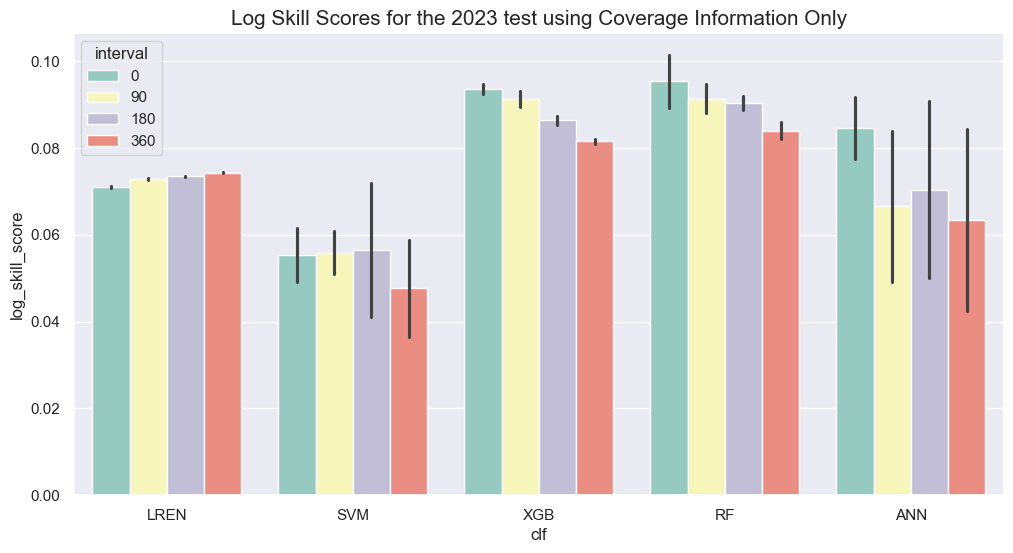

In [62]:
#Log loss skill score plot 2023
fig, ax = plt.subplots(figsize=(12,6))
query = 'year==2023'
result = cls_results_all.query(query)
sns.barplot(data=result, y='log_skill_score', x=result['clf'].str.upper(), 
            hue='interval', ax=ax, orient='v', palette='Set3', errorbar='sd')
ax.set_title('Log Skill Scores for the 2023 test using Coverage Information Only')
ax.title.set_size(15)
ax.legend(loc='upper left', title='interval')
plt.show()

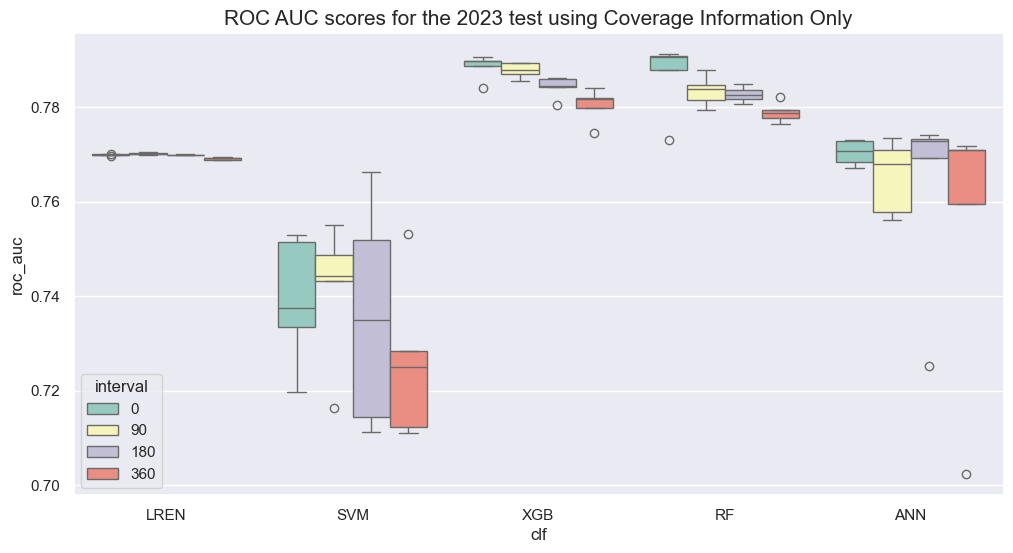

In [63]:
#ROC-AUC plot 2023
fig, ax = plt.subplots(figsize=(12,6))
query = 'year==2023'
result = cls_results_all.query(query).copy()
sns.boxplot(data=result, y='roc_auc', x=result['clf'].str.upper(), hue='interval', ax=ax, orient='v', palette='Set3')
ax.set_title('ROC AUC scores for the 2023 test using Coverage Information Only')
ax.title.set_size(15)
ax.legend(loc='lower left', title='interval')
plt.show()

### 2024 test

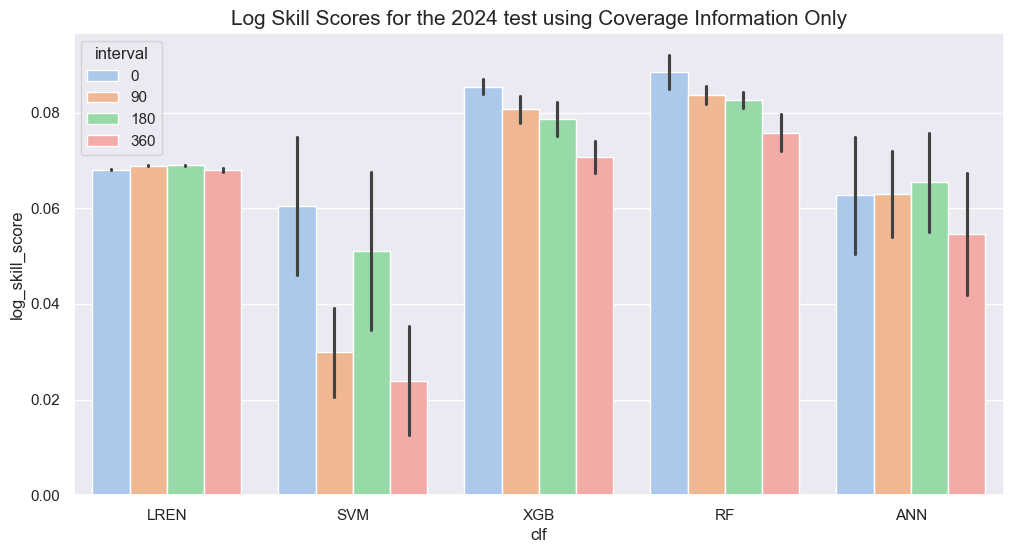

In [64]:
#Log loss skill score plot 2024
fig, ax = plt.subplots(figsize=(12,6))
query = 'year==2024'
result = cls_results_all.query(query)
sns.barplot(data=result, y='log_skill_score', x=result['clf'].str.upper(), 
            hue='interval', ax=ax, orient='v', palette='pastel', errorbar='sd')
ax.set_title('Log Skill Scores for the 2024 test using Coverage Information Only')
ax.title.set_size(15)
ax.legend(loc='upper left', title='interval')
plt.show()

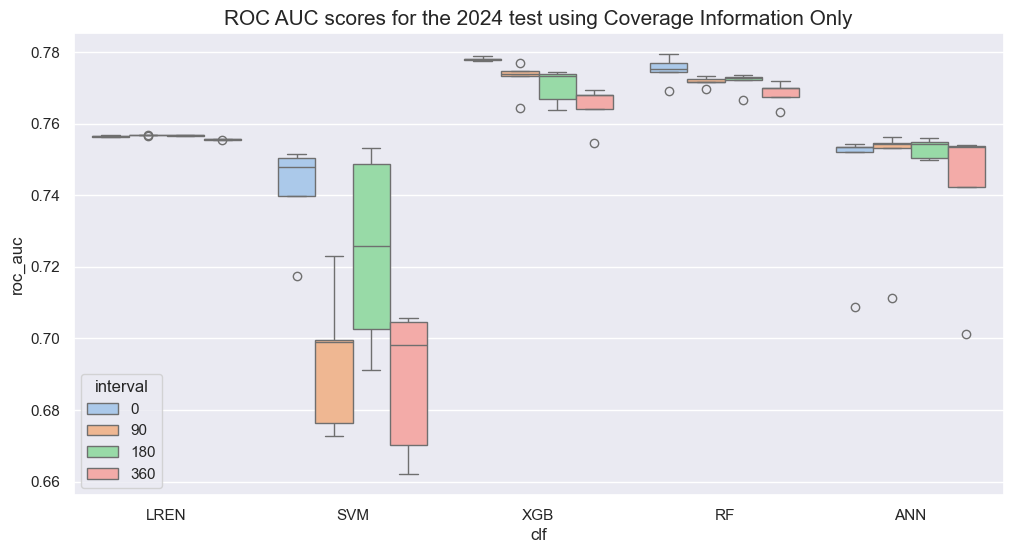

In [65]:
#ROC-AUC plot 2024
fig, ax = plt.subplots(figsize=(12,6))
query = 'year==2024'
result = cls_results_all.query(query).copy()
sns.boxplot(data=result, y='roc_auc', x=result['clf'].str.upper(), hue='interval', ax=ax, orient='v', palette='pastel')
ax.set_title('ROC AUC scores for the 2024 test using Coverage Information Only')
ax.title.set_size(15)
ax.legend(loc='lower left', title='interval')
plt.show()

## Best mean results
We also search the results dataframe to identify the model with the best mean log loss skill score in each experiment.\
It appears that the Random Forest algorithm most frequently gave the best probability estimates.

In [66]:
def best_clf_res(group):
    return group.loc[group['mean_log_skill'].idxmax(), :]

cls_means_calc = cls_results_all.groupby(['year', 'interval', 'clf'])\
                                .agg(mean_log_skill = ('log_skill_score', 'mean'),
                                     max_log_skill = ('log_skill_score', 'max'),
                                     min_log_skill = ('log_skill_score', 'min'),
                                     mean_auc = ('roc_auc', 'mean'),
                                     max_auc = ('roc_auc', 'max'),
                                     min_auc = ('roc_auc', 'min')
                                ).reset_index()

best_mean_scores = cls_means_calc.groupby(['year', 'interval'])\
                                 .apply(lambda g: best_clf_res(g), include_groups=False)\
                                 .reset_index()

In [67]:
best_mean_scores

,year,interval,clf,mean_log_skill,max_log_skill,min_log_skill,mean_auc,max_auc,min_auc
0,2023,0,rf,0.0953,0.0987,0.0846,0.787,0.791,0.773
1,2023,90,rf,0.0913,0.0957,0.0865,0.784,0.788,0.779
2,2023,180,rf,0.0903,0.0925,0.0885,0.783,0.785,0.781
3,2023,360,rf,0.084,0.0863,0.0811,0.779,0.782,0.777
4,2024,0,rf,0.0884,0.091,0.0823,0.775,0.779,0.769
5,2024,90,rf,0.0837,0.0849,0.0804,0.772,0.774,0.77
6,2024,180,rf,0.0827,0.0847,0.0803,0.772,0.774,0.767
7,2024,360,rf,0.0758,0.0782,0.0691,0.769,0.772,0.763


In [68]:
best_mean_scores.to_csv('RESULTS/best_model_cvg_only.csv', index=False)

## Demonstration of feature importance
Using the best model - the Random Forest, we can now experiment with feature importance analysis. \
These are limited experiments using only the 0 day offset interval. Feature importances are scored 20 times and averaged. \
Also, note that calibrated classifiers use ensemble estimators. Feature importances are extracted from each submodel in the ensemble.

### 2023 test

In [69]:
pm.set_params(year=2023, interval=0) #Set parameters for the experiment
fi_scores_23 = pd.DataFrame(columns=model_cols)
start = time.time()
for i in range(0, 20, 1): #Repeat 20 times
    best_clf = pm.get_best_estimator(rf, cv_params_rf, 10, 5) #Get an optimised RF clf
    #The estimator is an ensemble so we need to extract feature importances from each submodel
    for submodel in best_clf:
        submodel_fi = submodel.estimator['clf'].feature_importances_
        fi_score = pd.Series(data=submodel_fi, index=model_cols) #Extract feature importance scores
        fi_scores_23.loc[len(fi_scores_23), :] = fi_score
end = time.time()
print((end - start)/60)

22.641688712437947


In [70]:
fi_scores_23.shape

(100, 15)

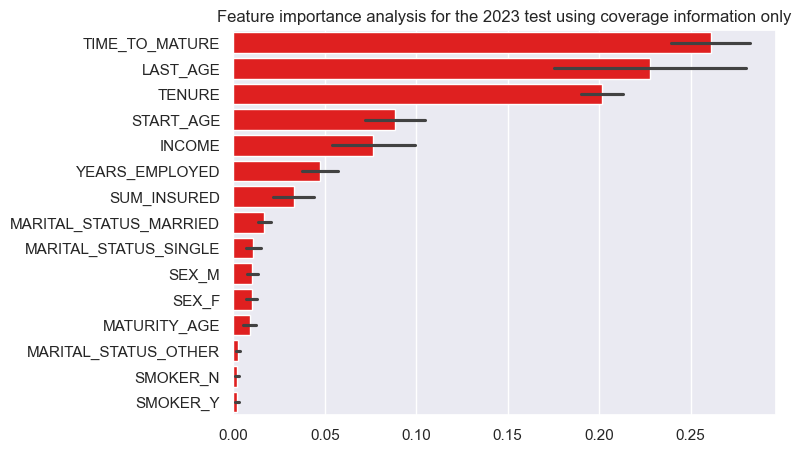

In [71]:
#Average the feature importance scores across the runs and plot
fig, ax = plt.subplots(figsize=(7,5))
feat_order = fi_scores_23.mean().sort_values(key=abs, ascending=False).index.values
sns.barplot(data=fi_scores_23, ax=ax, orient='h', color='red', errorbar='sd', order=feat_order)
ax.set_title('Feature importance analysis for the 2023 test using coverage information only')
ax.title.set_size(12)
plt.show()

### 2024 test

In [72]:
pm.set_params(year=2024, interval=0) #Set parameters for the experiment
fi_scores_24 = pd.DataFrame(columns=model_cols)
start = time.time()
for i in range(0, 20, 1): #Repeat 20 times
    best_clf = pm.get_best_estimator(rf, cv_params_rf, 10, 5) #Get an optimised RF clf
    #The estimator is an ensemble so we need to extract feature importances from each submodel
    for submodel in best_clf:
        submodel_fi = submodel.estimator['clf'].feature_importances_
        fi_score = pd.Series(data=submodel_fi, index=model_cols) #Extract feature importance scores
        fi_scores_24.loc[len(fi_scores_24), :] = fi_score
end = time.time()
print((end - start)/60)

24.34664556582769


In [73]:
fi_scores_24.shape

(100, 15)

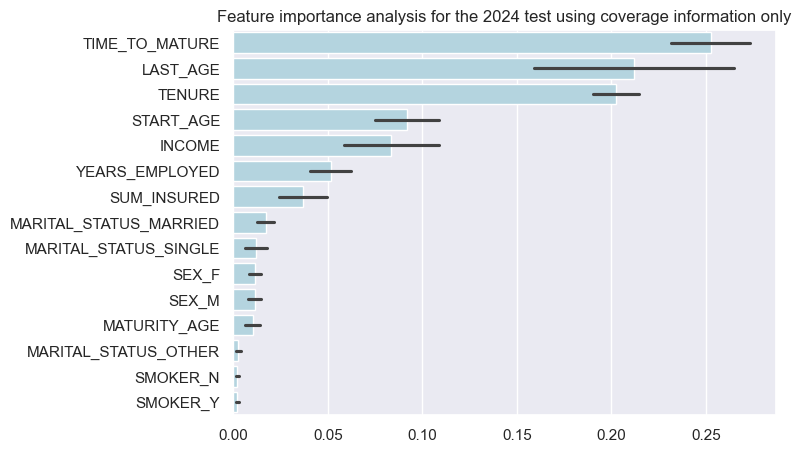

In [74]:
#Average the feature importance scores across the runs and plot
fig, ax = plt.subplots(figsize=(7,5))
feat_order = fi_scores_24.mean().sort_values(key=abs, ascending=False).index.values
sns.barplot(data=fi_scores_24, ax=ax, orient='h', color='lightblue', errorbar='sd', order=feat_order)
ax.set_title('Feature importance analysis for the 2024 test using coverage information only')
ax.title.set_size(12)
plt.show()

# Rank Score
Lastly, the best performing model - the Random Forest - is used to produce probability estimates for the coverages. These are then ranked in order of risk. Precision-at-K (PAK) and Recall-at-K (RAK) analysis is then performed. The experiment is repeated 5 times for numberical stability.

In [75]:
pm.set_params(test_years=[2023,2024], test_intervals=[0,90,180,360])
start = time.time()
ranking_results, mean_ranking_results = pm.repeated_ranking_analysis(rf, cv_params_rf, 10, 5, runs=5)
end = time.time()
print((end - start)/60)

43.45945563316345


In [76]:
print(ranking_results.shape, mean_ranking_results.shape)

(120, 6) (24, 6)


In [77]:
ranking_results.to_csv('RESULTS/ranking_results_cvg_only.csv', index=False)

In [78]:
mean_ranking_results.to_csv('RESULTS/mean_ranking_results_cvg_only.csv', index=False)

## 2023 test
Plots of the ranking analysis of the 2023 test.

In [79]:
mean_ranking_results.query('year==2023').sort_values(by=['interval', 'k'])

,year,interval,id,k,precision_at_k,recall_at_k
1,2023,0,Top10,10,0.3,0.00952
2,2023,0,Top20,20,0.21,0.0133
0,2023,0,Claim Rate,237,0.107,0.0806
4,2023,90,Top10,10,0.24,0.00762
5,2023,90,Top20,20,0.18,0.0114
3,2023,90,Claim Rate,237,0.105,0.0794
7,2023,180,Top10,10,0.12,0.00381
8,2023,180,Top20,20,0.11,0.00698
6,2023,180,Claim Rate,237,0.105,0.0787
10,2023,360,Top10,10,0.1,0.00317


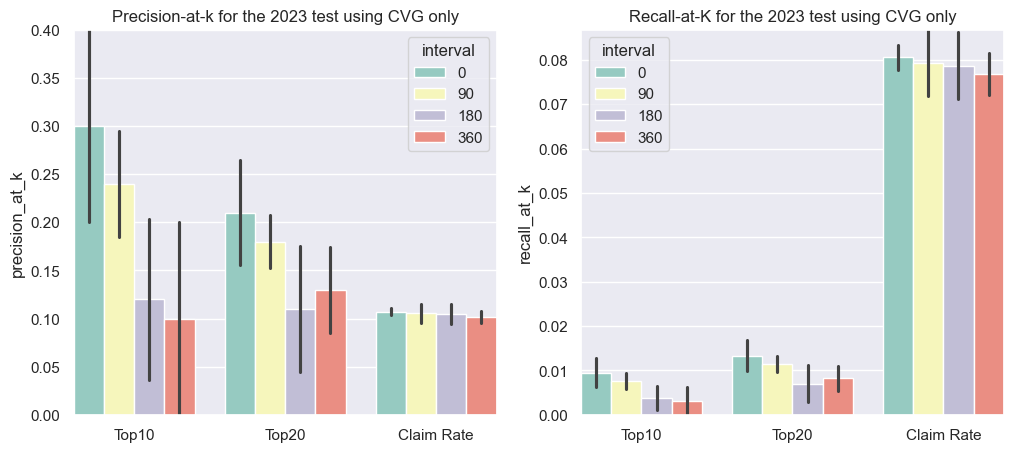

In [80]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
query = 'year==2023'
result = ranking_results.query(query).copy()
#Precision-at-k plot
sns.barplot(data=result, y='precision_at_k', x='id', hue='interval', ax=ax1, orient='v', errorbar='sd', palette='Set3')
ax1.set_title('Precision-at-k for the 2023 test using CVG only')
ax1.title.set_size(12)
ax1.set_xlabel('')
ax1.legend(loc='upper right', title='interval')
ax1.margins(0,0)
#Recall-at-k plot
sns.barplot(data=result, y='recall_at_k', x='id', hue='interval', ax=ax2, orient='v', errorbar='sd', palette='Set3')
ax2.set_title('Recall-at-K for the 2023 test using CVG only')
ax2.title.set_size(12)
ax2.set_xlabel('')
ax2.margins(0,0)
plt.show()

## 2024 test
Plots of the ranking analysis of the 2024 test.

In [81]:
mean_ranking_results.query('year==2024').sort_values(by=['interval', 'k'])

,year,interval,id,k,precision_at_k,recall_at_k
13,2024,0,Top10,10,0.4,0.0265
14,2024,0,Top20,20,0.28,0.0371
12,2024,0,Claim Rate,104,0.112,0.0768
16,2024,90,Top10,10,0.4,0.0265
17,2024,90,Top20,20,0.22,0.0291
15,2024,90,Claim Rate,104,0.112,0.0768
19,2024,180,Top10,10,0.28,0.0185
20,2024,180,Top20,20,0.27,0.0358
18,2024,180,Claim Rate,104,0.117,0.0808
22,2024,360,Top10,10,0.2,0.0132


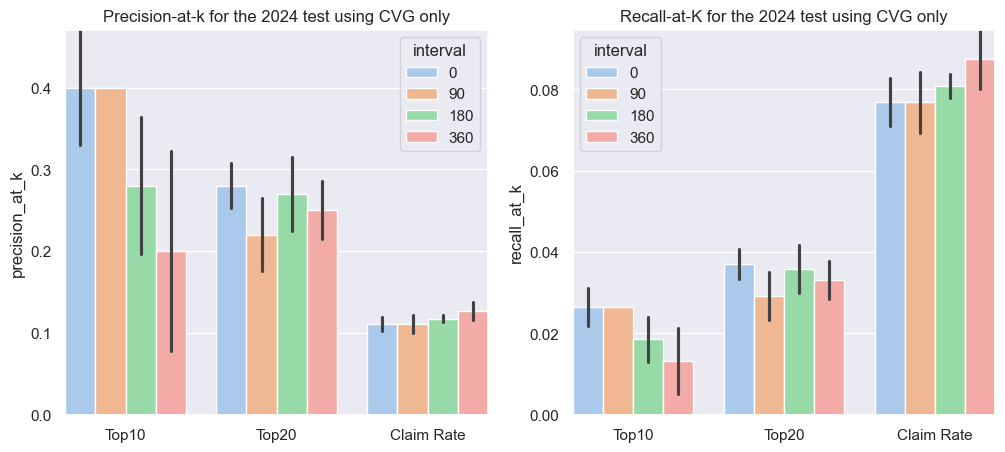

In [82]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
query = 'year==2024'
result = ranking_results.query(query).copy()
#Precision-at-k plot
sns.barplot(data=result, y='precision_at_k', x='id', hue='interval', ax=ax1, orient='v', errorbar='sd', palette='pastel')
ax1.set_title('Precision-at-k for the 2024 test using CVG only')
ax1.title.set_size(12)
ax1.set_xlabel('')
ax1.legend(loc='upper right', title='interval')
ax1.margins(0,0)
#Recall-at-k plot
sns.barplot(data=result, y='recall_at_k', x='id', hue='interval', ax=ax2, orient='v', errorbar='sd', palette='pastel')
ax2.set_title('Recall-at-K for the 2024 test using CVG only')
ax2.title.set_size(12)
ax2.set_xlabel('')
ax2.margins(0,0)
plt.show()